In [19]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis
import boring_stats as bs

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport boring_stats

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_base'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned ON


In [12]:
path = save_dir + 'ACCESS_radar_higher_wind_level/radar_63/63_2020_12.pkl'
with open(path, 'rb') as f:
    tracks_obj = pickle.load(f)

In [13]:
tracks_obj.params

{'SEARCH_MARGIN': 50000,
 'FLOW_MARGIN': 40000,
 'MAX_FLOW_MAG': 60,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 60,
 'MAX_SHIFT_DISP_ALT': 25,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1000,
 'LEVELS': array([[ 1000,  1500],
        [  500, 20000]]),
 'WIND_LEVELS': array([[  500,  3500],
        [  500, 20000]]),
 'MIN_SIZE': [80, 800],
 'FIELD_THRESH': ['convective', 15],
 'ISO_THRESH': [10, 10],
 'TRACK_INTERVAL': 0,
 'CELL_THRESH': 25,
 'CELL_START': 3000,
 'RAIN': False,
 'SAVE_RAIN': False,
 'AMBIENT': 'ERA5',
 'AMBIENT_BASE_DIR': '/g/data/w40/esh563/era5/pressure-levels/reanalysis/',
 'DT': 10,
 'CLASS_THRESH': {'OFFSET_MAG': 10000,
  'SHEAR_MAG': 2,
  'VEL_MAG': 5,
  'REL_VEL_MAG': 2,
  'ANGLE_BUFFER': 10},
 'EXCL_THRESH': {'SMALL_AREA': 500,
  'LARGE_AREA': 50000,
  'BORD_THRESH': 0.001,
  'MAJOR_AXIS_LENGTH': 100,
  'AXIS_RATIO': 3,
  'DURATION': 30},
 'INPUT_TYPE': 'OPER_DATETIMES',
 'REMOTE': True,
 'AMBIENT_TIMESTEP': 6,
 'SAVE_DIR': '/g/data/w40/esh563/TINT_tracks/',
 'REFERENCE_GRID_F

In [106]:
tracks_obj.tracks.xs(np.datetime64('2020-10-15T08:20:00'), level='time')[['u_shift', 'v_shift']]

u_shift  v_shift
scan uid level                  
2054 7   0       -1.668    4.168
         1       -1.668    4.168

In [21]:
tracks_dir = [
    'base', 'lower_conv_level', 'higher_conv_level', 'two_levels',
    'four_levels', 'no_steiner', 'lower_ref_thresh', 'combined']

years = sorted(list(set(range(1998, 2016)) - {2007, 2008, 2000}))

for d in tracks_dir:
    for year in years:
        path = save_dir + '{}/{}1001_{}0501.pkl'.format(
            d, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)
            
        print('Fixing')
        tracks_obj = cl.redo_exclusions(tracks_obj)
        
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calcula

In [22]:
conv_area_radar = []
strat_area_radar = []
times_radar = []

for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        years_months = [
            [year, 10], [year, 11], [year, 12],
            [year+1, 1], [year+1, 2], [year+1, 3],
            [year+1, 4]]
        for year_month in years_months:
            path = save_dir + 'radar_{}/{}_{}_{:02}.pkl'.format(
                radar, radar, year_month[0], year_month[1])
            with open(path, 'rb') as f:
                tracks_obj = pickle.load(f)

            tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
            print('Fixing.')
            with open(path, 'wb') as f:
                pickle.dump(tracks_obj, f)
                
                
conv_area_ACCESS = []
strat_area_ACCESS = []
times_ACCESS = []

Radar 63, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 63, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.


In [23]:
for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        path = save_dir + 'ACCESS_{}/{}1001_{}0501.pkl'.format(
            radar, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)

        tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
        print('Fixing.')
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Radar 63, year 2020.
Fixing.
Radar 63, year 2021.
Fixing.
Radar 42, year 2020.
Fixing.
Radar 42, year 2021.
Fixing.
Radar 77, year 2020.
Fixing.
Radar 77, year 2021.
Fixing.


# Generate Figures

In [23]:
radars=[63, 77, 42]
suff = 'all_radar'

In [21]:
all_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=None, radars=radars)
all_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=None, radars=radars)

weak_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=1, radars=radars)
weak_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=1, radars=radars)

active_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=2, radars=radars)
active_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=2, radars=radars)

Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Calculating system tracks.
Calcula

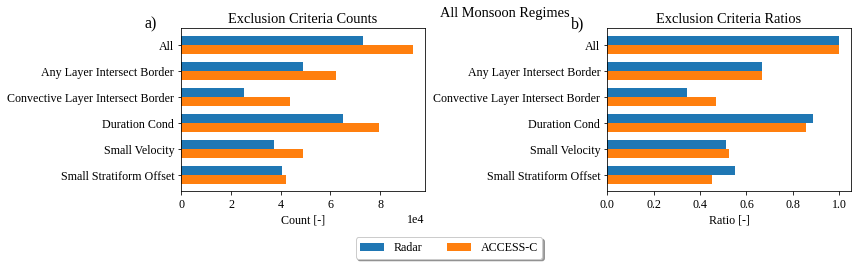

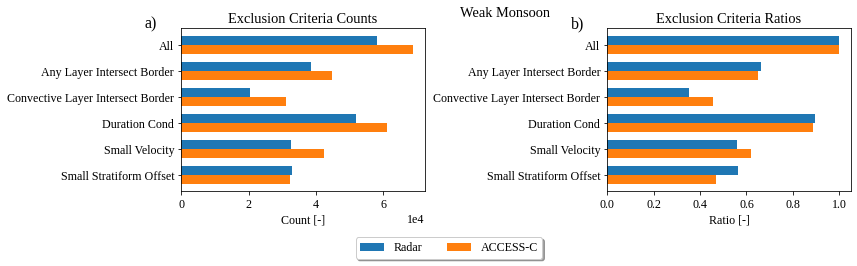

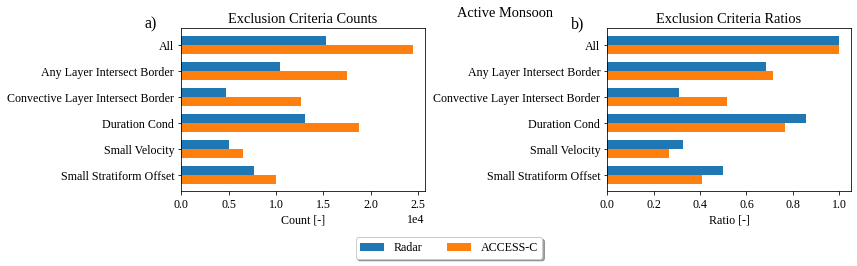

In [24]:
bs.compare_exclusions(all_excl_radar, all_excl_ACCESS, title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'excl_all.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(weak_excl_radar, weak_excl_ACCESS, title='Weak Monsoon')
plt.savefig(
    fig_dir + 'excl_weak.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(active_excl_radar, active_excl_ACCESS, title='Active Monsoon')
plt.savefig(
    fig_dir + 'excl_active.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [28]:
all_obs_radar = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], None, radars=radars)
QC_obs_radar = bs.get_boring_radar_stats(
    save_dir, None, None, radars=radars)

all_obs_weak_radar = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], 1, radars=radars)
QC_obs_weak_radar = bs.get_boring_radar_stats(
    save_dir, None, 1,
    radars=radars)

all_obs_active_radar = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], 2, radars=radars)
QC_obs_active_radar = bs.get_boring_radar_stats(
    save_dir, None, 2, radars=radars)

Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calc

Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 42, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 42, year 2021.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.


In [29]:
all_obs_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], None, radars=radars)
QC_obs_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, None, None, radars=radars)

all_obs_weak_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], 1, radars=radars)
QC_obs_weak_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, None, 1, radars=radars)

all_obs_active_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], 2, radars=radars)
QC_obs_active_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, None, 2, radars=radars)

Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system 

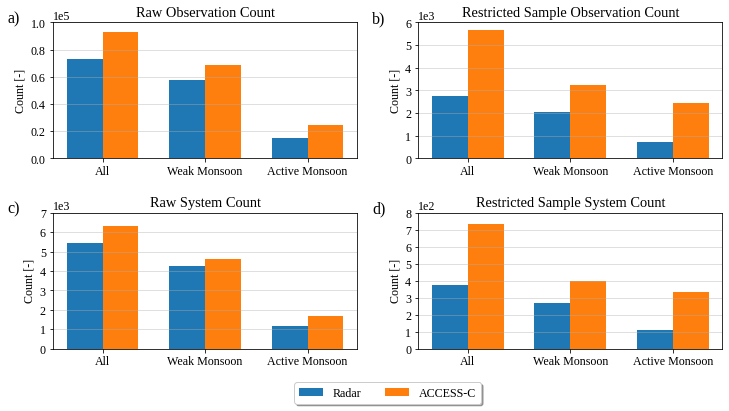

In [89]:
bs.plot_counts(
    all_obs_radar, all_obs_weak_radar, all_obs_active_radar,
    all_obs_ACCESS, all_obs_weak_ACCESS, all_obs_active_ACCESS,
    QC_obs_radar, QC_obs_weak_radar, QC_obs_active_radar,
    QC_obs_ACCESS, QC_obs_weak_ACCESS, QC_obs_active_ACCESS)
plt.savefig(
    fig_dir + 'totals_ACCESS_radar_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

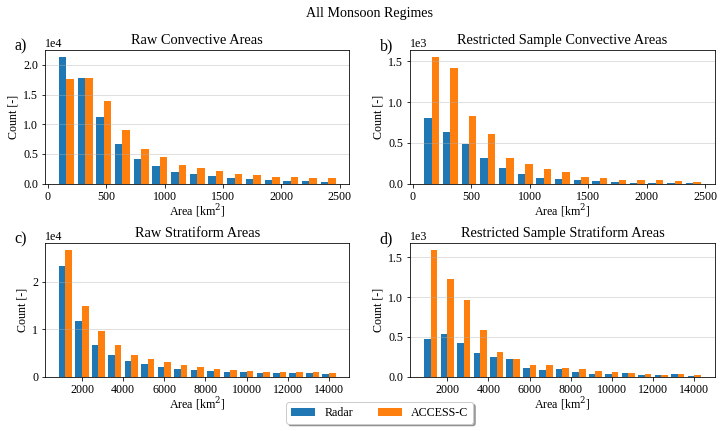

In [75]:
density = False

bs.compare_sizes(
    all_obs_radar, all_obs_ACCESS, 
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

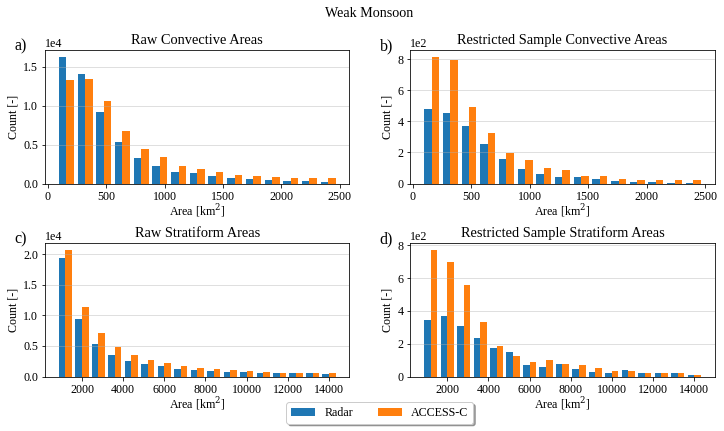

In [76]:
bs.compare_sizes(
    all_obs_weak_radar, all_obs_weak_ACCESS, 
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density,
    title='Weak Monsoon')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

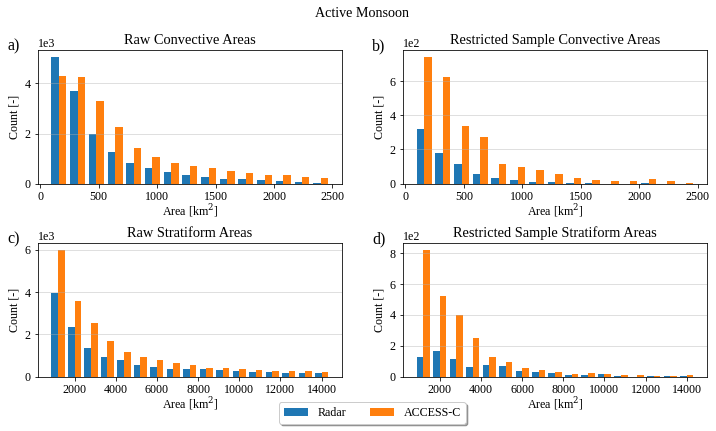

In [77]:
bs.compare_sizes(
    all_obs_active_radar, all_obs_active_ACCESS, 
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density,
    title='Active Monsoon')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

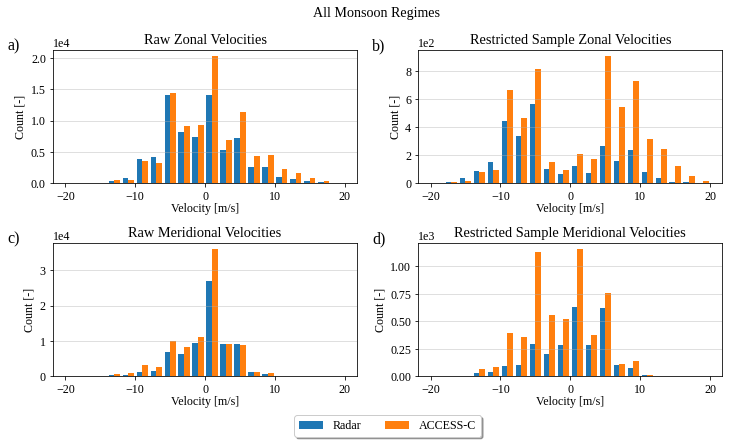

In [78]:
bs.compare_velocities(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'velocities_ACCESS_radar_all_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

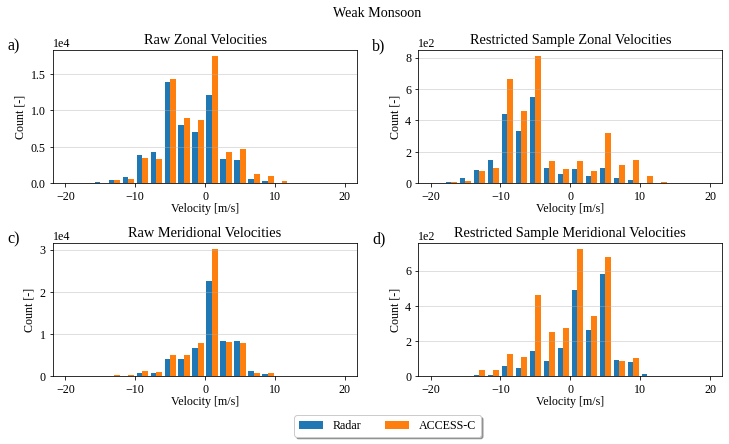

In [79]:
bs.compare_velocities(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, title='Weak Monsoon')
plt.savefig(
    fig_dir + 'velocities_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

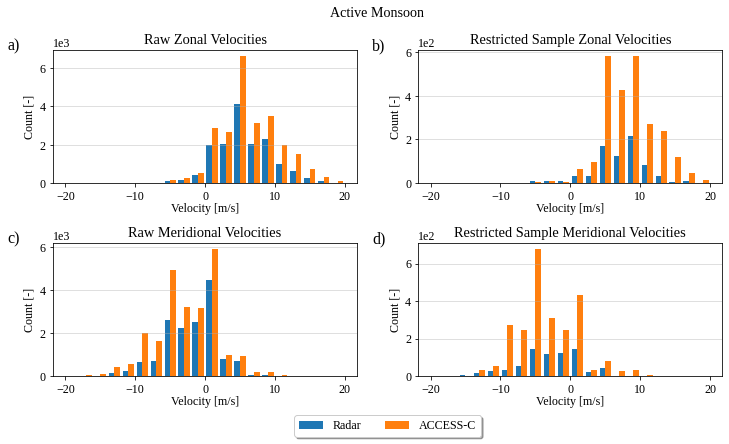

In [80]:
bs.compare_velocities(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, title='Active Monsoon')
plt.savefig(
    fig_dir + 'velocities_ACCESS_radar_active_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

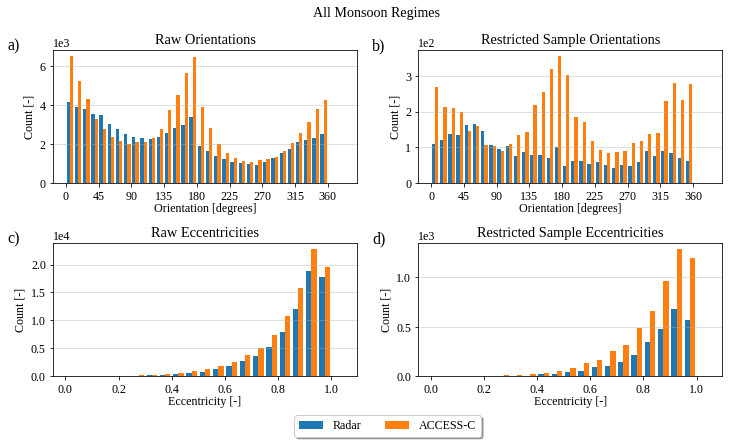

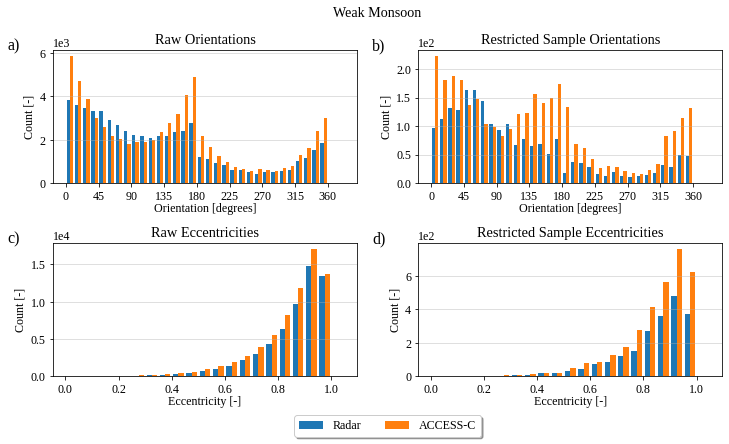

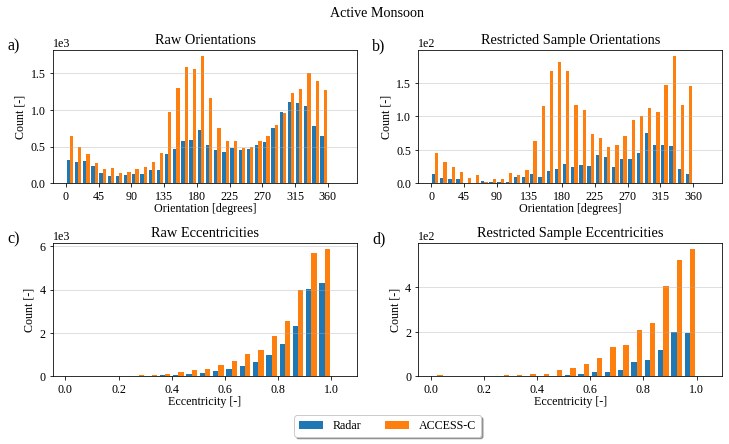

In [81]:
bs.compare_shape(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_all_{}.png'.format(suff), 
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

bs.compare_shape(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

bs.compare_shape(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_active_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

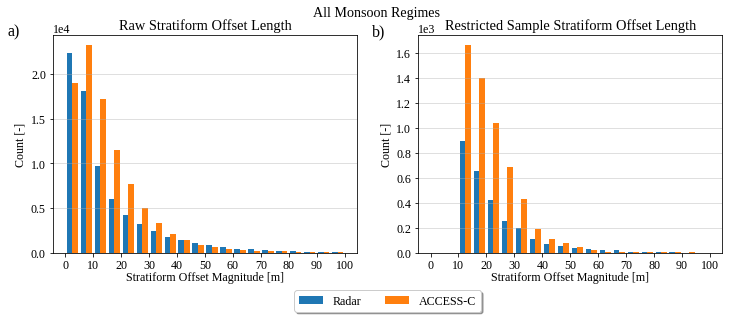

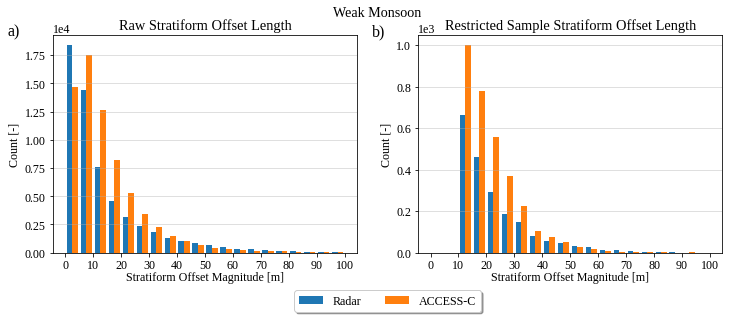

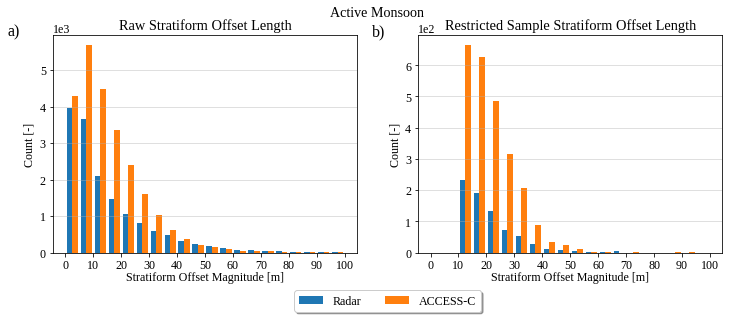

In [112]:
density = False

bs.compare_offset(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_all_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_offset(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_offset(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_active_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

In [25]:
bs.compare_time(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'time_ACCESS_radar_all_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_time(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'time_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_time(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'time_ACCESS_radar_active_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

NameError: name 'all_obs_radar' is not defined

> /tmp/ipykernel_5947/1079900918.py(2)<module>()
      1 bs.compare_time(
----> 2     all_obs_radar, all_obs_ACCESS,
      3     QC_obs_radar, QC_obs_ACCESS, density=density,
      4     title='All Monsoon Regimes')
      5 

ipdb> q


In [144]:
test = pd.DataFrame({'time': pd.to_datetime(all_obs_radar[2])})
test.groupby(test['time'].dt.hour).value_col.sum()

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_col'

(array([104., 191., 166., 200., 253., 347., 374., 351., 327., 314., 271.,
        190., 164., 167., 203., 252., 256., 258., 297., 259., 203., 214.,
        210., 112.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

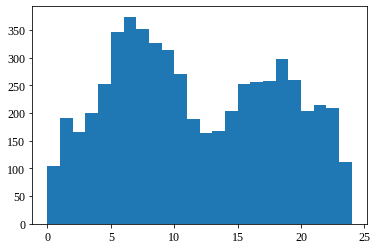

In [156]:
plt.hist([int(s.astype(str)[11:13]) for s in QC_obs_ACCESS[2]], bins=np.arange(0,25,1))

(array([ 30.,  48.,  65.,  72.,  86., 106., 148., 218., 314., 287., 256.,
        150., 121., 116., 114.,  97.,  67.,  78.,  82., 103.,  92.,  66.,
         37.,  22.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

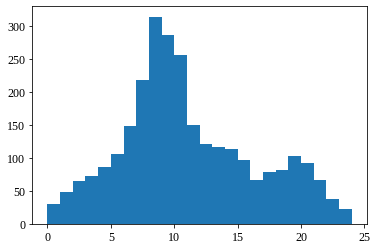

In [157]:
plt.hist([int(s.astype(str)[11:13]) for s in QC_obs_radar[2]], bins=np.arange(0,25,1))

In [30]:
path = save_dir + 'ACCESS_63/20201001_20210501.pkl'
with open(path, 'rb') as f:
    tracks_obj = pickle.load(f)

In [37]:
tracks_obj.tracks.xs(np.datetime64('2021-01-28T12:00:00'), level='time')['u_shift']

scan   uid   level
17064  1269  0        5.000
             1        5.000
       1271  0        9.167
             1        9.167
Name: u_shift, dtype: float64

In [38]:
tracks_obj.tracks_class.xs(np.datetime64('2021-01-28T12:00:00'), level='time')

grid_x        grid_y        lon       lat  \
scan  uid  level                                                    
17064 1269 0      60118.122101  25379.714966  131.47821 -12.22820   
           1      43296.489716  34788.036346  131.32329 -12.14385   
      1271 0       4565.944672 -79595.475197  130.96717 -13.17282   
           1     -22168.731689 -59760.751724  130.72040 -12.99436   

                                        inflow_type  \
scan  uid  level                                      
17064 1269 0                               Rear Fed   
           1                              Front Fed   
      1271 0      Ambiguous (Low Relative Velocity)   
           1                              Front Fed   

                                   propagation_type        tilt_type  \
scan  uid  level                                                       
17064 1269 0                   Up-Shear Propagating  Up-Shear Tilted   
           1                   Up-Shear Propagating  Up-Shear Tilted   
      1271 0      Ambiguous (Low Relative Velocity)  Up-Shear Tilted   
           1                   Up-Shear Propagating  Up-Shear Tilted   

                          offset_type              rel_offset_type  
scan  uid  level                                                    
17064 1269 0      Trailing Stratiform  Relative Leading Stratiform  
           1      Trailing Stratiform  Relative Leading Stratiform  
      1271 0      Trailing Stratiform   Ambiguous (Small Velocity)  
           1      Trailing Stratiform  Relative Leading Stratiform

In [192]:
exclusions = [
    'small_area', 'large_area', 'intersect_border',
    'intersect_border_convective', 'duration_cond',
    'small_velocity', 'small_offset']

In [193]:
excluded = tracks_obj.exclusions[exclusions]
excluded = np.any(excluded, 1)
included = np.logical_not(excluded)

sub_classes = tracks_obj.tracks_class.where(included==True).dropna()

inds_all = sub_classes.index.values
sub_tracks_all = tracks_obj.tracks.loc[inds_all]

In [194]:
inds = sub_tracks_all['orientation'].where(
    sub_tracks_all['orientation']>135).dropna().where(
    sub_tracks_all['orientation']<225).dropna().index
# inds = sub_tracks_all['orientation'].where(
#     sub_tracks_all['orientation']<40).dropna().where(
#     sub_tracks_all['orientation']<40).dropna().index
lons = sub_tracks_all['lon'].loc[inds].values
lats = sub_tracks_all['lat'].loc[inds].values
times = [ind[1] for ind in inds]

In [195]:
times

[Timestamp('2020-12-02 04:00:00'),
 Timestamp('2020-12-02 04:00:00'),
 Timestamp('2020-12-02 04:10:00'),
 Timestamp('2020-12-02 04:10:00'),
 Timestamp('2020-12-03 20:30:00'),
 Timestamp('2020-12-04 01:10:00'),
 Timestamp('2020-12-04 07:30:00'),
 Timestamp('2020-12-04 07:50:00'),
 Timestamp('2020-12-04 08:00:00'),
 Timestamp('2020-12-04 08:00:00'),
 Timestamp('2020-12-04 09:40:00'),
 Timestamp('2020-12-04 18:30:00'),
 Timestamp('2020-12-04 18:40:00'),
 Timestamp('2020-12-04 18:40:00'),
 Timestamp('2020-12-04 18:40:00'),
 Timestamp('2020-12-04 18:50:00'),
 Timestamp('2020-12-04 18:50:00'),
 Timestamp('2020-12-04 18:50:00'),
 Timestamp('2020-12-04 19:00:00'),
 Timestamp('2020-12-04 19:00:00'),
 Timestamp('2020-12-04 19:10:00'),
 Timestamp('2020-12-04 19:10:00'),
 Timestamp('2020-12-04 19:20:00'),
 Timestamp('2020-12-04 19:30:00'),
 Timestamp('2020-12-04 19:40:00'),
 Timestamp('2020-12-04 19:40:00'),
 Timestamp('2020-12-04 19:50:00'),
 Timestamp('2020-12-04 19:50:00'),
 Timestamp('2020-12-

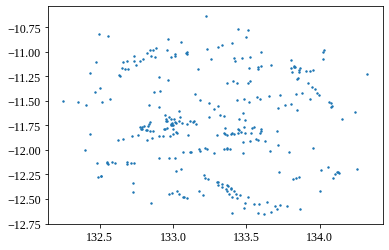

In [190]:
plt.scatter(lons, lats, s=2)

In [419]:
test = xr.open_dataset('https://dapds00.nci.org.au/thredds/dodsC/wr45/ops_aps3/access-dn/1/20200925/0600/an/ml/wnd_ucmp.nc')

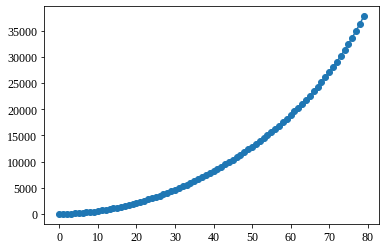

In [425]:
plt.plot(test.rho_lvl.values, '-o')

In [ ]:
test = xr.open_dataset('https://dapds00.nci.org.au/thredds/dodsC/wr45/ops_aps3/access-dn/1/20200925/0600/an/ml/wnd_ucmp.nc')

In [114]:
path = save_dir + 'ACCESS_radar_ambient_swapped/ACCESS_63/20201001_20210501.pkl'
with open(path, 'rb') as f:
    tracks_obj = pickle.load(f)

scan   time                 uid   level
457    2020-10-04 04:10:00  0     0       NaN
                                  1       NaN
458    2020-10-04 04:20:00  0     0       NaN
                                  1       NaN
459    2020-10-04 04:30:00  0     0       NaN
                                           ..
29691  2021-04-28 12:30:00  2290  1       NaN
29692  2021-04-28 12:40:00  2290  0       NaN
                                  1       NaN
29693  2021-04-28 12:50:00  2290  0       NaN
                                  1       NaN
Name: u_ambient_mid, Length: 43814, dtype: float64